In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [3]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func

In [4]:
# create engine to hawaii.sqlite
engine = create_engine("sqlite:///Resources/hawaii.sqlite")
conn = engine.connect()

In [5]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(autoload_with=engine)


In [6]:
# View all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [7]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [8]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Precipitation Analysis

In [9]:
# Find the most recent date in the data set.
# ('2017-08-23',)
recent = session.query(Measurement.date).order_by(Measurement.date.desc()).first()[0]
recent

'2017-08-23'

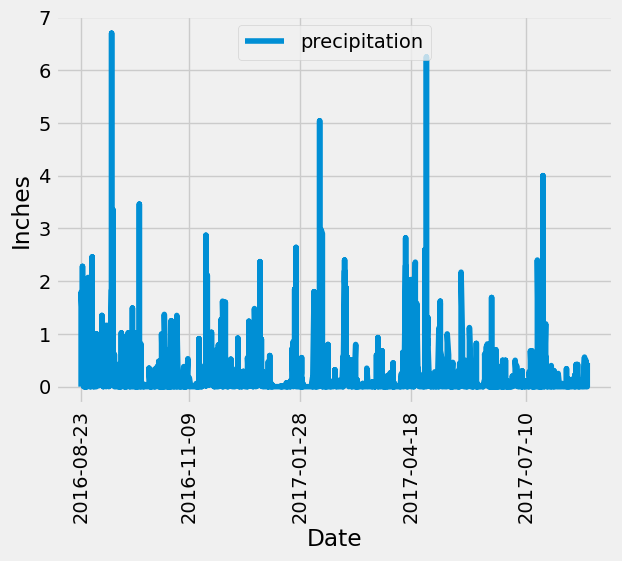

In [10]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results. 
# Starting from the most recent data point in the database. 

# Calculate the date one year from the last date in data set.
one_year_ago = dt.date(int(recent[0:4]), int(recent[5:7]), int(recent[8:10])) - dt.timedelta(days=365) #'2016-08-23'

# Perform a query to retrieve the data and precipitation scores
data = session.query(Measurement.date, Measurement.prcp).\
    filter(Measurement.date.between(one_year_ago, recent)).all()


# Save the query results as a Pandas DataFrame. Explicitly set the column names
df = pd.DataFrame(data, columns=['date', 'prcp'])
df = df.dropna(how='any')

# Sort the dataframe by date
df = df.sort_values('date')

# Use Pandas Plotting with Matplotlib to plot the data
x_values = df['date']
y_values = df['prcp']
ticks = ['2016-08-23', '2016-11-09', '2017-01-28', '2017-04-18', '2017-07-10']
tick_labels = ['2016-08-23', '2016-11-09', '2017-01-28', '2017-04-18', '2017-07-10']

plt.plot(x_values, y_values, label='precipitation')
plt.xlabel('Date')
plt.ylabel('Inches')
plt.xticks(ticks, tick_labels, rotation=90)
plt.legend(loc='upper center')
plt.show()


In [11]:
# Use Pandas to calculate the summary statistics for the precipitation data
sum_stats = pd.DataFrame(df['prcp'].describe())
sum_stats = sum_stats.rename(columns={"prcp": "precipitation"})
sum_stats


,precipitation
count,2021.000000
mean,0.177279
std,0.461190
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


# Exploratory Station Analysis

In [12]:
# Design a query to calculate the total number of stations in the dataset
num_stations = session.query(func.count(Station.station)).all()
num_stations


[(9,)]

In [13]:
# Design a query to find the most active stations (i.e. which stations have the most rows?)
# List the stations and their counts in descending order.
from sqlalchemy import desc

active_stations = session.query(Measurement.station, func.count(Measurement.station)).group_by(Measurement.station).order_by(desc(func.count(Measurement.station))).all() #How do I order this?
active_stations

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [14]:
# Using the most active station id from the previous query, calculate the lowest, highest, and average temperature.
ma_station = active_stations[0][0] #'USC00519281'

session.query(func.min(Measurement.tobs), func.max(Measurement.tobs), func.avg(Measurement.tobs)).\
    filter(Measurement.station == ma_station).all()

[(54.0, 85.0, 71.66378066378067)]

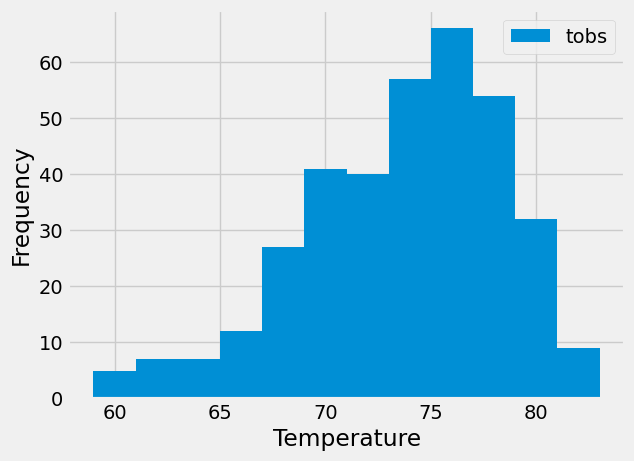

In [16]:
# Using the most active station id
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram

#Find the most recent date for this station
date_one = session.query(Measurement.date).\
    filter(Measurement.station == ma_station).\
    order_by(Measurement.date.desc()).first()[0] #'2017-08-18'
qd_one = dt.date(int(date_one[0:4]), int(date_one[5:7]), int(date_one[8:10]))
qd_two = qd_one - dt.timedelta(days=365)

data = session.query(Measurement.tobs).\
    filter(Measurement.station == ma_station).\
    filter(Measurement.date.between(qd_two, qd_one)).all()

df = pd.DataFrame(data, columns=['temperature'])

plt.hist(df, 12, label='tobs')
plt.xlabel('Temperature')
plt.ylabel('Frequency')
plt.legend(loc='upper right')
plt.show()


# Close Session

In [17]:
# Close Session
session.close()